In [1]:
import numpy as np
import Scripts.cifar_resnet as rn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from math import ceil
%matplotlib inline

In [2]:
importlib.reload(rn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

In [3]:
RS = 24

## Training Data

In [4]:
real_wakes_data = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes_1000.npy")
not_wakes_day_data = np.load("Data\\Wake data\\negative_samples_3000_day.npy")
not_wakes_all_data = np.load("Data\\Wake data\\negative_samples_3000.npy")
real_wakes = real_wakes_data[:,:,:-1,:]
not_wakes = not_wakes_day_data[:,:,:-1,:]
not_wakes_all = not_wakes_day_data[:,:,:-1,:]

## Train function

In [5]:
def train_rn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

In [6]:
def smooth_prediction(x, net, sigma, num = 100, batch_size = 10):
    net.eval()
    x = x.float()
    with torch.no_grad():
        counts = np.zeros(2, dtype=int)
        for _ in range(ceil(num / batch_size)):
            this_batch_size = min(batch_size, num)
            num -= this_batch_size
            batch = x.repeat((this_batch_size, 1, 1, 1)).to(device)
            noise = torch.randn_like(batch, device=device) * sigma
            noisy_batch = batch + noise
            b_max = noisy_batch.max()
            b_min = noisy_batch.min()
            noisy_batch = (noisy_batch - b_min)/(b_max-b_min)
            predictions = net(noisy_batch).argmax(1)   
            counts_update = np.zeros(2, dtype=int)
            for idx in predictions.cpu().numpy():
                counts[idx] += 1
            counts += counts_update
        pred = counts.argmax() 
    return pred

In [7]:
def make_plots(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label = 'Train loss')
    plt.plot(val_losses, label = 'Validation loss')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-entropy loss')
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(train_accs, label = 'Train accuracy')
    plt.plot(val_accs, label = 'Validation accuracy')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15

## Experiment: Randomized Smoothing model
### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [9]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.387, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 1/6, test_size = 75/3000, random_state = RS)

In [10]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [11]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [12]:
resnet_1 = None
resnet_1 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.2882, Val Loss:0.1969, Train Acc:0.881000, Val Acc:0.9400
Epoch:2, Loss:0.1652, Val Loss:0.3188, Train Acc:0.938000, Val Acc:0.8733
Epoch:3, Loss:0.1090, Val Loss:0.1582, Train Acc:0.954000, Val Acc:0.9533
Epoch:4, Loss:0.0507, Val Loss:0.1596, Train Acc:0.986000, Val Acc:0.9467
Epoch:5, Loss:0.0413, Val Loss:0.2038, Train Acc:0.984000, Val Acc:0.9467
Epoch:6, Loss:0.0265, Val Loss:0.2018, Train Acc:0.991000, Val Acc:0.9400
Epoch:7, Loss:0.0278, Val Loss:0.2084, Train Acc:0.988000, Val Acc:0.9200
Epoch:8, Loss:0.0369, Val Loss:0.1316, Train Acc:0.987000, Val Acc:0.9733
Epoch:9, Loss:0.0088, Val Loss:0.1421, Train Acc:0.998000, Val Acc:0.9667
Epoch:10, Loss:0.0073, Val Loss:0.2244, Train Acc:0.997000, Val Acc:0.9400
Epoch:11, Loss:0.0011, Val Loss:0.1576, Train Acc:1.000000, Val Acc:0.9733
Epoch:12, Loss:0.0006, Val Loss:0.1715, Train Acc:1.000000, Val Acc:0.9600
Epoch:13, Loss:0.0003, Val Loss:0.1774, Train Acc:1.000000, Val Acc:0.9600
Epoch:14, Loss:0.0002, Val Loss:0.

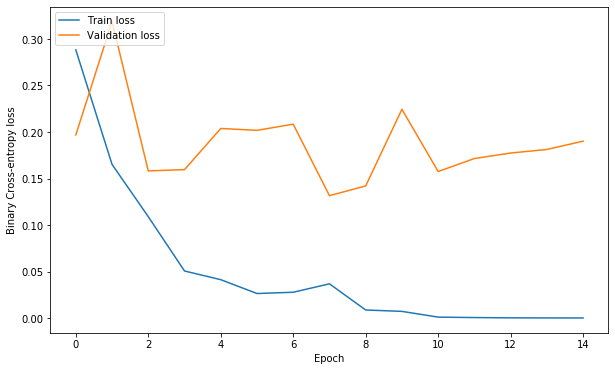

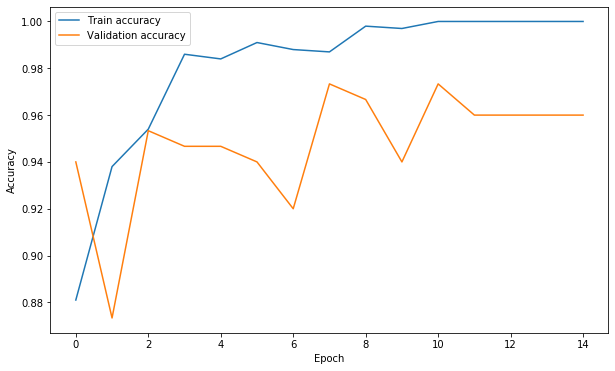

In [13]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment: Smoothing with noisy data
## Smoothing Sigma = 0.05
### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [14]:
smooth_sigma = 0.03
correct_predictions = test_y.argmax(1)

In [22]:
sigma = 0.3
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.3, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.3, Test Accuracy: 0.5533


In [23]:
sigma = 0.25
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.25, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.25, Test Accuracy: 0.6067


In [24]:
sigma = 0.2
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.2, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.2, Test Accuracy: 0.5867


In [25]:
sigma = 0.15
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.15, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.15, Test Accuracy: 0.7133


In [26]:
sigma = 0.1
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.1, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.1, Test Accuracy: 0.8


In [27]:
sigma = 0.05
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.05, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.05, Test Accuracy: 0.8667


In [28]:
sigma = 0.01
noise = torch.randn_like(torch.Tensor(test_x))*sigma
test_x_noisy = torch.Tensor(test_x) + noise
t_max = test_x_noisy.max()
t_min = test_x_noisy.min()
t_mm = t_max-t_min
test_x_noisy_norm = (test_x_noisy - t_min)/(t_max-t_min)
smooth_predictions = []
for frame in test_x_noisy_norm:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = smooth_sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.01, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.01, Test Accuracy: 0.9267
